In [1]:
#%tensorflow_version 2.x
#%activate tensorflow-gpu
import tensorflow as tf
## Fix for Fail to find the dnn implementation
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



1 Physical GPUs, 1 Logical GPUs
2.1.0
/device:GPU:0
Num GPUs Available:  1


In [2]:
#Lib imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from sklearn.metrics import confusion_matrix
import sys, os, io, string, shutil, math
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn import preprocessing
from IPython.display import display
import scipy.linalg as la
import re
from tabulate import tabulate
from scipy import stats
import pickle
from sklearn.utils import shuffle
import random
import time
tf.keras.backend.set_floatx('float64')
tf.__version__

'2.1.0'

In [3]:
dataset_dir = '../../data/'
saved_models_dir = '../../models/'

with open(dataset_dir+'DW_1000T_1x.pk', 'rb') as handle:
    (input_list, all_data, training_indexes, testing_indexes) = pickle.load(handle)

print(len(input_list))
print(all_data.shape)
print(len(training_indexes))
print(len(testing_indexes))

160
(160, 9999, 6)
100
60


In [0]:
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(all_data_selected.reshape(-1,1))
#sc = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#sc = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#sc = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#sc = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
#arr_transformed = sc.fit_transform(arr_selected)
#scaled_data = scaled_data.reshape(-1,1000,1)
#scaled_data =all_data_selected

(19900, 5)
(19900,)


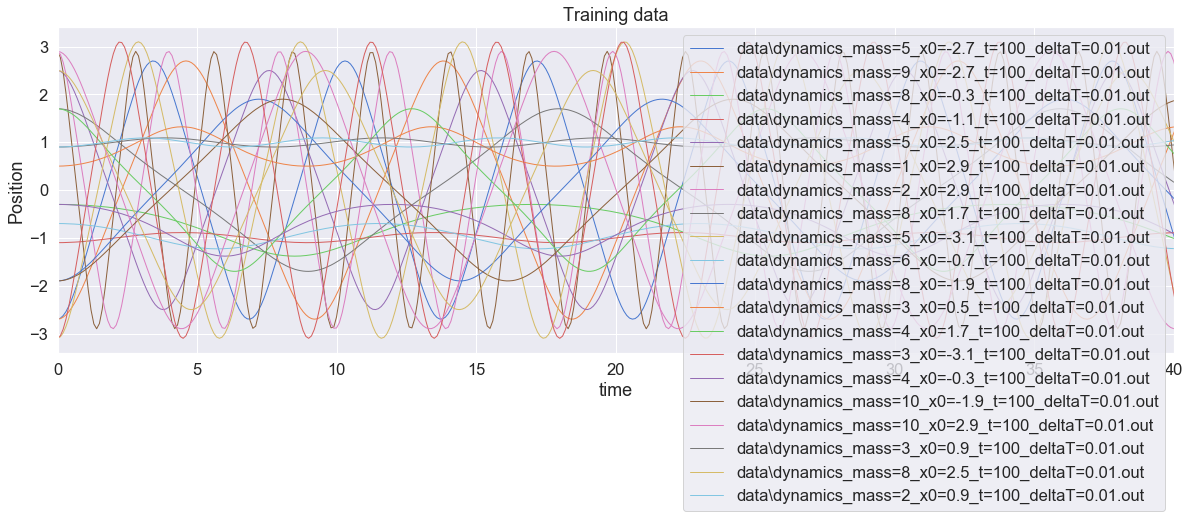

In [4]:
fig=plt.figure(figsize=(20, 6))
plt.title('Training data')

reduction_factor =10
window_size=5
input_data = []
output = []

for sim_ in training_indexes[0:20]:
  selected_data = all_data[sim_][::reduction_factor,1]  # 6 referes to actual cos solution
  plt.plot(all_data[sim_][::reduction_factor,0], selected_data, label=input_list[sim_], linewidth=1, markersize=3)
  for i in range(window_size, selected_data.shape[0]):
        input_data.append(selected_data[(i-window_size):i])
        output.append(selected_data[i])

plt.xlabel('time')
plt.ylabel('Position')
plt.legend()
#plt.ylim(-2.5, 10)
plt.xlim(0, 40)

input_data = np.array(input_data)
output = np.array(output)
print(input_data.shape)
print(output.shape)

In [5]:
input_data_suff, output_suff  = shuffle(input_data, output)

train_test_split = 0.80
train_test_split_ = int(input_data_suff.shape[0]*train_test_split)

x_train = input_data_suff[0:train_test_split_].reshape(-1,window_size,1)
x_test = input_data_suff[train_test_split_:].reshape(-1,window_size,1)
y_train = output_suff[0:train_test_split_].reshape(-1,1)
y_test = output_suff[train_test_split_:].reshape(-1,1)

print("input: ", input_data_suff.shape)
print("Output", output_suff.shape)
print("Train input: ", x_train.shape)
print("Train Output", y_train.shape)
print("Test input: ", x_test.shape)
print("Test Output", y_test.shape)

input:  (19900, 5)
Output (19900,)
Train input:  (15920, 5, 1)
Train Output (15920, 1)
Test input:  (3980, 5, 1)
Test Output (3980, 1)


In [6]:
# hyper parameters
learningRate = 0.001
batchSize = 128
dropout_rate=0.1
input_features=1

#input_shape = (None, input_features)   #batchsize, timesteps, input_dim: this is a bad example here timesteps, input_dim are height and width
input_shape = (window_size, input_features) 

# Network Parameters
lstmUnits1 = 32       # 1st layer number of neurons
lstmUnits2 = 32       # 2nd layer number of neurons
#lstmUnits3 = 64 
output_shape = input_features     # 


dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(20).batch(batchSize)
input_shape

(5, 1)

### Loss function

In [7]:
def loss_func(targets, logits):
    #print(targets.shape)
    #print(logits.shape)
    #loss = tf.reduce_mean(tf.square(logits - targets))
    #reduce_sum
    loss = tf.math.reduce_mean(tf.keras.losses.mean_squared_error(targets, logits))
    return loss

### Learning rate scheduling and optimization

In [8]:
class WarmupThenDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Learning schedule for training the Transformer
    Attributes:
        model_size: d_model in the paper (depth size of the model)
        warmup_steps: number of warmup steps at the beginning
    """
    def __init__(self, model_size, warmup_steps=4000):
        super(WarmupThenDecaySchedule, self).__init__()

        self.model_size = model_size
        self.model_size = tf.cast(self.model_size, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step_term = tf.math.rsqrt(step)
        warmup_term = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.model_size) * tf.math.minimum(step_term, warmup_term)


#lr = WarmupThenDecaySchedule(MODEL_SIZE)
lr = learningRate
'''
#ptimizer = tf.keras.optimizers.Adam(lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
'''
optimizer = tf.keras.optimizers.Adam(lr)

### LSTM model

In [9]:

class LSTM_Model(tf.keras.Model):
    """ Class for the LSTM model
        Args:
        input_shape: 

    """
    def __init__(self, input_shape_lstm, dropout_rate, lstmUnits1, lstmUnits2, output_shape_dense):
        super(LSTM_Model, self).__init__()
        self.seed = None
        self.init_model = 'fan_in'
        self.init_distribution = 'truncated_normal'
        self.initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode=self.init_model, distribution=self.init_distribution, seed=self.seed)

        ## LSTM LAYER 01
        self.input_shape_lstm = input_shape_lstm
        self.lstm1_size = lstmUnits1
        self.dropout_rate = dropout_rate
        self.lstm1 = tf.keras.layers.LSTM(self.lstm1_size, kernel_initializer=self.initializer, input_shape=self.input_shape_lstm, return_sequences=True)
        self.batchNormal1 = None
        self.batchNormal1 = tf.keras.layers.BatchNormalization()
        self.activation1 = tf.keras.layers.Activation('relu')
        self.dropout1 = tf.keras.layers.Dropout(rate=self.dropout_rate)

        ## LSTM LAYER 02
        self.lstm2_size = lstmUnits2
        self.lstm2 = tf.keras.layers.LSTM(self.lstm2_size, kernel_initializer=self.initializer)
        self.batchNormal2 = None
        self.batchNormal2 = tf.keras.layers.BatchNormalization()
        self.activation2 = tf.keras.layers.Activation('relu')
        self.dropout2 = tf.keras.layers.Dropout(rate=self.dropout_rate)

        ## Dense LAYER
        self.output_shape_dense = output_shape_dense
        self.dense1 = tf.keras.layers.Dense(self.output_shape_dense, activation=None, kernel_initializer=self.initializer)


    def call(self, sequence, training=True):
        """ Forward pass for the LSTM
            Args:
              sequence: source input sequences
              training: whether training or not (for Dropout)

            Returns:
              The output of the LSTM networkk (batch_size, input features)

        """

        lstm_out = self.lstm1(sequence)
        #print(lstm_out.shape)
        if self.batchNormal1:
            lstm_out = self.batchNormal1(lstm_out)
        lstm_out = self.activation1(lstm_out)
        if training:
            lstm_out = self.dropout1(lstm_out)

        lstm_out = self.lstm2(lstm_out)
        if self.batchNormal2:
            lstm_out = self.batchNormal2(lstm_out)
        lstm_out = self.activation2(lstm_out)
        if training:
            lstm_out = self.dropout2(lstm_out)    

        fc_output = self.dense1(lstm_out)

        return fc_output



lstm_model = LSTM_Model(input_shape, dropout_rate, lstmUnits1, lstmUnits2, output_shape)
sequence_in = np.random.random([1, 5, 1]).astype(np.float64)
model_output= lstm_model(sequence_in)
print(sequence_in.shape)
print(model_output)
print(model_output.shape)

(1, 5, 1)
tf.Tensor([[0.04645413]], shape=(1, 1), dtype=float64)
(1, 1)


### training function

In [10]:
@tf.function
def train_step(source_seq, target_seq_out):
    """ Execute one training step (forward pass + backward pass)
    Args:
        source_seq: source sequences
        target_seq_in: input target sequences (x0,x1,....xn)
        target_seq_out: output target sequences (xn+1)
    
    Returns:
        The loss value of the current pass
    """
    with tf.GradientTape() as tape:
        
        model_output = lstm_model(source_seq)
        #print(model_output.shape)

        loss = loss_func(target_seq_out, model_output)

    variables = lstm_model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

### Forward path

In [11]:
def predict(test_source=None):
    """ Predict the output sentence for a given input sentence
    Args:
        test_source_text: input sentence 
    
    Returns:
    print("Test input: ", x_test.shape)
    print("Test Output", y_test.shape)   
    """
    target_test = None
    loss=-1.0
    if test_source is None:
        test_source = x_test
        target_test = y_test

    en_output = lstm_model(test_source, training=False)

    if target_test is not None:
      loss = loss_func(target_test, en_output)
      #print("Test data loss: {}".format(loss.numpy()))

      return loss.numpy(), en_output
    else:
      return en_output

### Train Loop

In [12]:
epochs=10

train_loss = []
test_loss = []

starttime = time.time()
for e in range(epochs):
  loss_value=0.0
  train_batch_loss=[]
  for batch, (source_seq, target_seq_out) in enumerate(dataset.take(-1)):
    #print(source_seq.shape)
    #print(target_seq_out.shape)
    loss = train_step(source_seq, target_seq_out)
    #break
    #print(loss)
    loss_value = loss.numpy()
    train_batch_loss.append(loss_value)
    #if batch % 1000 == 0:
    #  print('Epoch {} Batch {} Traing batch Loss {} Elapsed time {:.2f}s'.format(e + 1, batch, loss_value, time.time() - starttime)) 
  train_loss.append(np.mean(train_batch_loss))
  try:
    #pass
    loss_value, _ = predict()
    test_loss.append(loss_value)
    print('Epoch {}, Training Loss {}, Test Loss {}, Elapsed time {:.2f}s'.format(e + 1, train_loss[-1], test_loss[-1], time.time() - starttime)) 
    starttime = time.time()
  except Exception as e:
    print(e)
    continue

Epoch 1, Training Loss 0.7885436412357069, Test Loss 0.2210793574623247, Elapsed time 3.15s
Epoch 2, Training Loss 0.09711463124803558, Test Loss 0.026433958761631852, Elapsed time 0.51s
Epoch 3, Training Loss 0.013380268273894389, Test Loss 0.006783262652815436, Elapsed time 0.48s
Epoch 4, Training Loss 0.005039020644747137, Test Loss 0.003340437358457703, Elapsed time 0.49s
Epoch 5, Training Loss 0.0030563395199577374, Test Loss 0.0023384395245669124, Elapsed time 0.48s
Epoch 6, Training Loss 0.002321311827391071, Test Loss 0.002157183517787421, Elapsed time 0.49s
Epoch 7, Training Loss 0.0019640152858807674, Test Loss 0.0016741091505967699, Elapsed time 0.47s
Epoch 8, Training Loss 0.001757540803167099, Test Loss 0.0016626866509888837, Elapsed time 0.49s
Epoch 9, Training Loss 0.0015801488824294736, Test Loss 0.0014555848982315321, Elapsed time 0.48s
Epoch 10, Training Loss 0.0014064552491174825, Test Loss 0.0013574225034385294, Elapsed time 0.49s


INFO:tensorflow:Assets written to: ../../models/DW.HDF5\assets


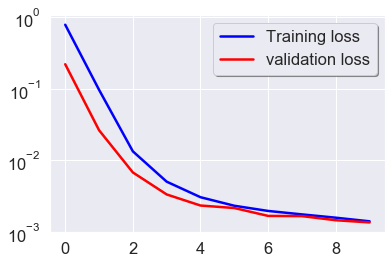

In [15]:
# This is 8 time frames
#model.evaluate(x_test, y_test)
# Save the model as a hdf5 file
# if you get folder creation error, manually create the folder
#tf.keras.models.save_model(model=lstm_model,filepath=saved_models_dir+'DW.HDF5')

fig, ax = plt.subplots(1,1)
ax.plot(train_loss, color='b', label="Training loss")
ax.plot(test_loss, color='r', label="validation loss",axes =ax)
plt.yscale('log')
legend = ax.legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)

In [18]:
# Take a look at the model summary
lstm_model.summary()

Model: "lstm__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  4352      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8320      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
activation_1 (Activation)    multiple                  

In [20]:
# Load the keras model
lstm_model = tf.keras.models.load_model(filepath=saved_models_dir+'DW.HDF5', compile=True)
#y_pred = model.predict(x_test)
#y_pred_classes = model.predict_classes(x_test)
#cm = confusion_matrix(y_test_classes, y_pred_classes)
#print(cm)

(995,)
(995,)
(995,)


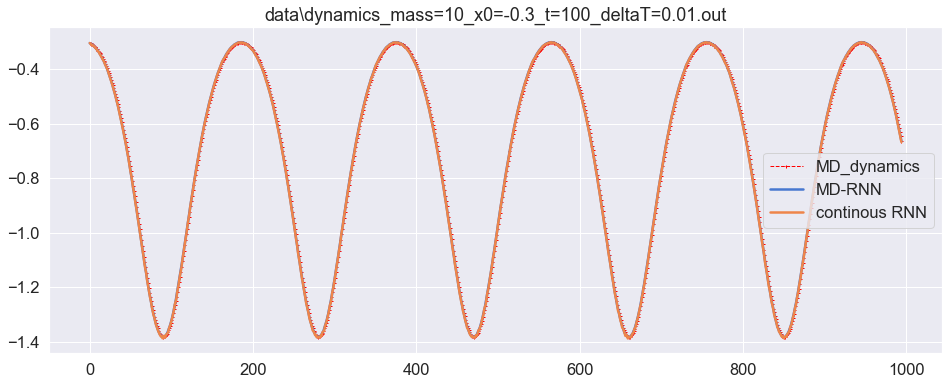

In [21]:
#sim_ =training_indexes[0]
sim_ =testing_indexes[0]

selected_data = all_data[sim_][::reduction_factor,1]

actual_output = []
predicted_output = []

for i in range(window_size, selected_data.shape[0]):
  predicted_output.append(predict(selected_data[(i-window_size):i].reshape(-1, window_size, 1)))
  actual_output.append(selected_data[i])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = selected_data[0:window_size]
temp__ = np.append(temp__, predicted_output, axis=0)

for i in range(window_size, selected_data.shape[0]):
  Only_RNN_predicted_output.append(predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)


print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
plt.plot(predicted_output, label='MD-RNN')
plt.plot(Only_RNN_predicted_output, label='continous RNN')

plt.legend()
